In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *

In [5]:
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

Total memory: 16914055168
Free memory: 16902979584
Used memory: 11075584


In [ ]:
# import torch
# print(torch.cuda.is_available())

In [ ]:
# #Utilities for collecting/checking fastai user environment
# import fastai.utils.collect_env
# fastai.utils.collect_env.show_install()

In [ ]:
# #Suggest how to improve the setup to speed things up
# fastai.utils.check_perf()

In [ ]:
!wget https://raw.githubusercontent.com/fastai/course-nlp/master/nlputils.py

In [6]:
# bs=48
# bs=24
bs=128

In [7]:
data_path = Config.data_path() #PosixPath('/home/jupyter/.fastai/data')
lang = 'fr'
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
dest = path/'docs'
lm_fns = [f'{lang}_wt_spm', f'{lang}_wt_vocab_spm'] #['vi_wt_bwd', 'vi_wt_vocab_bwd']

In [8]:
path

PosixPath('/home/jupyter/.fastai/data/frwiki')

In [9]:
cd {path} 


/home/jupyter/.fastai/data/frwiki


In [10]:
from fastai.basics import *
import re


def get_wiki(path,lang):
    name = f'{lang}wiki'
    if (path/name).exists():
        print(f"{path/name} already exists; not downloading")
        return

    xml_fn = f"{lang}wiki-latest-pages-articles.xml"
    zip_fn = f"{xml_fn}.bz2"

    if not (path/xml_fn).exists():
        print("downloading...")
        download_url(f'https://dumps.wikimedia.org/{name}/latest/{zip_fn}', path/zip_fn)
        print("unzipping...")
        bunzip(path/zip_fn)

    with working_directory(path):
        if not (path/'wikiextractor').exists(): os.system('git clone https://github.com/attardi/wikiextractor.git')
        print("extracting...")
        os.system("python wikiextractor/WikiExtractor.py --processes 4 --no_templates " +
            f"--min_text_length 2500 --filter_disambig_pages --log_file log -b 100G -q {xml_fn}")
    shutil.move(str(path/'text/AA/wiki_00'), str(path/name))
    shutil.rmtree(path/'text')


def split_wiki(path,lang):
    dest = path/'docs'
    name = f'{lang}wiki'
    if dest.exists():
        print(f"{dest} already exists; not splitting")
        return dest

    dest.mkdir(exist_ok=True, parents=True)
    title_re = re.compile(rf'<doc id="\d+" url="https://{lang}.wikipedia.org/wiki\?curid=\d+" title="([^"]+)">')
    lines = (path/name).open()
    f=None

    for i,l in enumerate(lines):
        if i%100000 == 0: print(i)
        if l.startswith('<doc id="'):
            title = title_re.findall(l)[0].replace('/','_')
            if len(title)>150: continue
            if f: f.close()
            f = (dest/f'{title}.txt').open('w')
        else: f.write(l)
    f.close()
    return dest

In [ ]:
#from nlputils import split_wiki,get_wiki

In [ ]:
#!rm -rf /home/jupyter/.fastai/data/frwiki

In [11]:
get_wiki(path,lang) #downloads wiki 
#makes log, {lang}wiki {lang}wiki-latest pages

/home/jupyter/.fastai/data/frwiki/frwiki already exists; not downloading


In [12]:
ls

docs/             frwiki-latest-pages-articles.xml      models/
fr_databunch_spm  frwiki-latest-pages-articles.xml.bz2  wikiextractor/
frwiki            log


In [13]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/frwiki/wikiextractor'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/frwiki-latest-pages-articles.xml'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/log'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/frwiki'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/models'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/frwiki-latest-pages-articles.xml.bz2'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/fr_databunch_spm')]

In [14]:
!head -n4 {path}/{name}

<doc id="3" url="https://fr.wikipedia.org/wiki?curid=3" title="Antoine Meillet">
Antoine Meillet

Paul Jules Antoine Meillet, né le à Moulins (Allier) et mort le à Châteaumeillant (Cher), est le principal linguiste français des premières décennies du . Il est aussiphilologue.


In [15]:
#This function splits the single wikipedia file into a separate file per article. 
#This is often easier to work with.
dest = split_wiki(path,lang)

/home/jupyter/.fastai/data/frwiki/docs already exists; not splitting


In [ ]:
## used to remove the docs directory because I couldnt get it to create databuches
#!rm -rf /home/jupyter/.fastai/data/frwiki/docs

In [16]:
dest.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Blood (groupe japonais).txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Émile Garet.txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Trois beautés de notre temps.txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Louis Charbonnier.txt'),
 PosixPath('/home/jupyter/.fastai/data/frwiki/docs/Mark Andrews (catch).txt')]

In [17]:
# dest = path/'docs' 
dest

PosixPath('/home/jupyter/.fastai/data/frwiki/docs')

In [18]:
#PRINT NUMBER OF FILES IN DIR
! find /home/jupyter/.fastai/data/frwiki/docs -mindepth 1 -maxdepth 1 -printf '.' | wc -c

369528


In [ ]:
#REMOVE ALL BUT 1O FILES
#ls -1tr | head -n -10 | xargs -d '\n' rm -f --

In [ ]:
#! find /home/jupyter/.fastai/data/frwiki/docs -mindepth 1 -maxdepth 1 -printf '.' | wc -c

In [ ]:
#print size
#ls -l * 

In [19]:
!pip install sentencepiece

In [ ]:
data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor()])
        .split_by_rand_pct(0.1, seed=42)
        .label_for_lm()
        .databunch(bs=bs, num_workers=-1))

data.save(f'{lang}_databunch_spm')
len(data.vocab.itos),len(data.train_ds)

In [ ]:
data.save(f'/home/jupyter/.fastai/data/frwiki/{lang}_databunch_spm')

In [32]:
ls

docs/             frwiki-latest-pages-articles.xml      models/
fr_databunch_spm  frwiki-latest-pages-articles.xml.bz2  wikiextractor/
frwiki            log


In [20]:
data = load_data(path, f'{lang}_databunch_spm', bs=bs)

In [21]:
data.show_batch()

idx,text
0,"▁guitare , ▁mais ▁également ▁des ▁art works ▁; ▁xxmaj ▁ka e de ▁apporte ▁sa ▁contribution ▁par ▁son ▁jeu ▁de ▁basse , ▁de ▁syn th - basse , ▁son ▁sens ▁de ▁l ' aspect ▁visuel ▁du ▁groupe ▁et ▁aussi ▁la ▁composition ▁des ▁paroles . ▁xxmaj ▁ce ▁duo ▁est ▁le ▁noyau ▁du ▁groupe , ▁aidé ▁par ▁le ▁chanteur ▁et ▁con teur ▁fu ~ ki ▁et ▁de ▁divers ▁membres ▁invités . ▁xxmaj ▁la"
1,"née ), ▁ou ▁par ▁rétention ▁du ▁souffle ▁( cons équ ence ▁d ' une ▁ oc clus ion ▁dans ▁la ▁gorge , ▁la ▁bouche , ▁ou ▁le ▁nez ). ▁xxmaj ▁la ▁respiration ▁qui ▁porte ▁une ▁voix ▁peut ▁alors ▁chanter , ▁et ▁parler , ▁pour ▁ exprimer ▁des ▁sentiments ▁et ▁des ▁pensées . ▁xxmaj ▁pour ▁passer ▁de ▁la ▁tra chée ▁au ▁go s ier , ▁le ▁souffle ▁traverse ▁les ▁cordes ▁vocale"
2,"▁trône ▁passe ▁à ▁l ' ars acide ▁xxmaj ▁tir ida te . ▁xxmaj ▁après ▁un ▁règne ▁d ' un ▁an ▁de ▁xxmaj ▁tir ida te , ▁xxmaj ▁art a ban ▁rassemble ▁une ▁grande ▁ armée ▁et ▁marche ▁contre ▁l ' ars acide ▁qui ▁se ▁réfugie ▁à ▁xxmaj ▁rome , ▁où ▁il ▁est ▁contraint ▁de ▁se ▁retirer , ▁et ▁xxmaj ▁tibère ▁doit ▁accepter ▁que ▁la ▁xxmaj ▁par thie ▁soit ▁gouverné e"
3,"▁explique ▁xxmaj ▁mary line ▁xxmaj ▁bau mard , ▁du ▁"" monde "", ▁c ' est ▁que ▁les ▁moyens ▁n ' ont ▁pas ▁été ▁à ▁la ▁hauteur ▁et ▁que ▁xxmaj ▁pour ▁xxmaj ▁raymond ▁xxmaj ▁boud on , ▁en ▁1973, ▁les ▁familles ▁d ' origine ▁sociale ▁élevée ▁favorisent ▁les ▁études ▁longues ▁et ▁donc ▁la ▁position ▁sociale ▁: ▁« ▁l ' effet ▁de ▁domina nce ▁» ▁est ▁supérieur ▁à ▁« ▁l ' effet"
4,"' être ▁transformée s ▁par ▁la ▁construction ▁du ▁barrage . ▁xxmaj ▁il ▁fait ▁l ' objet ▁d ' un ▁projet ▁de ▁réhabilitation , ▁commencé ▁en ▁novembre ▁2012. ▁xxmaj ▁selon ▁le ▁directeur ▁des ▁travaux , ▁xxmaj ▁sé r gio ▁xxmaj ▁fernando , ▁la ▁réhabilitation ▁devait ▁coût er ▁2 25 ▁millions ▁de ▁dollars . ▁xxmaj ▁différents ▁projets ▁val or isant ▁les ▁eaux ▁du ▁xxmaj ▁c une ne ▁se ▁heurte nt ▁cependant ▁à"


In [22]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.1, wd=0.1, pretrained=False).to_fp16()

In [23]:
learn.lr_find(stop_div=False, num_it=200)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-04
Min loss divided by 10: 8.32E-03


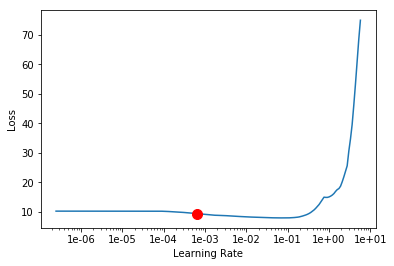

In [24]:
learn.recorder.plot(suggestion=True)

In [25]:
lr = 3e-3
lr *= bs/48  # Scale learning rate by batch size

In [26]:
learn.unfreeze()
learn.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.437698,3.565603,0.335589,1:38:43
1,3.548075,3.764708,0.315992,1:39:00
2,3.586027,3.844715,0.308992,1:39:08
3,3.576425,3.815418,0.311360,1:39:46
4,3.547993,3.756743,0.315985,1:39:48
5,3.485285,3.660113,0.325745,1:39:09
6,3.382548,3.529665,0.339174,1:38:59
7,3.262681,3.374384,0.356717,1:38:45
8,3.192425,3.216748,0.377390,1:39:03
9,3.185382,3.127606,0.390926,1:39:01


In [28]:
learn.to_fp32().save(lm_fns[0], with_opt=False)
learn.data.vocab.save(lm_fns[1].with_suffix('.pkl'))

AttributeError: 'str' object has no attribute 'with_suffix'

In [36]:
learn.to_fp32().export('/home/jupyter/tutorials/fastai/course-v3/nbs/learner_mod_fr_spm.pkl')

In [30]:
learn.data.vocab.save('/home/jupyter/tutorials/fastai/course-v3/nbs/learner_vocab_fr_spm.pkl')

In [31]:
learn.save_encoder('/home/jupyter/tutorials/fastai/course-v3/nbs/learner_fr_spm_enc')

In [37]:
learn.to_fp32().save('/home/jupyter/tutorials/fastai/course-v3/nbs/learner_mod_fr_spm_save.pkl',return_path=True)

PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/learner_mod_fr_spm_save.pkl.pth')

In [34]:
learn.to_fp32().export('/home/jupyter/tutorials/fastai/course-v3/nbs/learner_mod_fr_spm_export.pkl')

In [38]:
pwd

'/home/jupyter/.fastai/data/frwiki'

In [39]:
ls


docs/             frwiki-latest-pages-articles.xml      models/
fr_databunch_spm  frwiki-latest-pages-articles.xml.bz2  wikiextractor/
frwiki            log


In [40]:
cd docs

/home/jupyter/.fastai/data/frwiki/docs


In [50]:
# list all folders
!ls -d */ -a

models/  tmp/


In [52]:
mv tmp/ /home/jupyter/tutorials/fastai/course-v3/nbs/

In [48]:
mv /home/vivek/data/ /nas/home/vivek/archived/

spm.model  spm.vocab


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

In [ ]:
learn.purge()

In [ ]:
learn.destroy()